Import libs

In [1]:
# Data libs
import pandas as pd
import numpy as np

# Plotting libs
import seaborn as sns
import matplotlib.pyplot as plt
from plotly.subplots import make_subplots

# ML libs
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer

Let's take a look at the train data

In [2]:
train_data = pd.read_csv('train.csv')

train_data.head()

,Unnamed: 0,category,clicks,likes,buys,4xx_errors,5xx_errors,complaints_count,average_dwelltime,source_attractiveness,date_of_registration
0,6622,ecom,6488536.0,NaN,0,82221,0,0,18.450527,0.461750,2020-04-21 16:04:41.817367072
1,2047,information_source,874840.0,21100.0,0,12872,0,0,10.721619,-0.022317,2024-07-19 23:50:07.268931816
2,1118,information_source,571210.0,94707.0,0,0,7420,0,1.922243,0.046396,2024-07-13 16:35:54.794883135
3,4992,news,89534.0,924.0,0,834,0,0,2.149243,-0.093360,2024-09-10 21:29:14.006315095
4,9970,information_source,1043953.0,289288.0,0,58375,20260,3948,3.764965,0.027303,2024-05-26 11:07:15.950527838


In [3]:
missing_values = train_data.isnull().sum()
print(f'Missing values per column:\n{missing_values}')

Missing values per column:
Unnamed: 0                 0
category                   0
clicks                   273
likes                    376
buys                       0
4xx_errors                 0
5xx_errors                 0
complaints_count         473
average_dwelltime          0
source_attractiveness      0
date_of_registration       0
dtype: int64


In [4]:
print(train_data.dtypes)

train_data.describe()

Unnamed: 0                 int64
category                  object
clicks                   float64
likes                    float64
buys                       int64
4xx_errors                 int64
5xx_errors                 int64
complaints_count          object
average_dwelltime        float64
source_attractiveness    float64
date_of_registration      object
dtype: object


,Unnamed: 0,clicks,likes,buys,4xx_errors,5xx_errors,average_dwelltime,source_attractiveness
count,8000.000000,7.727000e+03,7.624000e+03,8.000000e+03,8.000000e+03,8.000000e+03,8000.000000,8000.000000
mean,5006.138875,2.749785e+06,5.985027e+05,5.810509e+05,8.204958e+04,2.769224e+04,6.979549,0.191997
std,2893.886162,4.699120e+06,1.978345e+06,2.262221e+06,1.555219e+05,7.946935e+04,10.004924,0.227873
min,0.000000,5.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-1.000000,-0.681718
25%,2493.250000,3.599210e+05,0.000000e+00,0.000000e+00,2.943000e+03,0.000000e+00,1.503928,0.038220
50%,5035.000000,1.097221e+06,3.399550e+04,0.000000e+00,2.671750e+04,0.000000e+00,4.022802,0.154256
75%,7521.250000,2.915358e+06,2.860638e+05,0.000000e+00,9.500225e+04,2.016375e+04,8.899400,0.282510
max,9999.000000,6.203206e+07,5.582181e+07,4.277391e+07,2.904996e+06,1.865588e+06,211.218066,1.355736


Let's fix some data format inaccuracies. Also swap date_of_registration feature to age

In [5]:
df = train_data.copy(deep=True)

df.rename(columns={'Unnamed: 0': 'ID'}, inplace=True)
df.set_index('ID', inplace=True)

df['date_of_registration'] = pd.to_datetime(df['date_of_registration'])
df['age'] = (pd.Timestamp('2024-09-30') - df['date_of_registration']) / pd.Timedelta(days=365)
df.drop('date_of_registration', axis='columns', inplace=True)

numerical_features = [
    'clicks', 
    'likes', 
    'buys', 
    '4xx_errors', 
    '5xx_errors',
    'complaints_count', 
    'average_dwelltime', 
    'source_attractiveness',
    'age'
]

category_features = [
    'category_information_source',	
    'category_news',	
    'category_porn',	
    'category_social'
]

for feature in numerical_features:
    df[feature] = pd.to_numeric(df[feature], errors='coerce')

Let's encode categorical features to build correlation matrix

In [6]:
encoded = df.copy(deep=True)
encoded = pd.get_dummies(encoded, columns=['category'], drop_first=True, dtype=int)
encoded.head()

,clicks,likes,buys,4xx_errors,5xx_errors,complaints_count,average_dwelltime,source_attractiveness,age,category_information_source,category_news,category_porn,category_social
ID,,,,,,,,,,,,,
6622,6488536.0,NaN,0,82221,0,0.0,18.450527,0.461750,4.444740,0,0,0,0
2047,874840.0,21100.0,0,12872,0,0.0,10.721619,-0.022317,0.197279,1,0,0,0
1118,571210.0,94707.0,0,0,7420,0.0,1.922243,0.046396,0.214544,1,0,0,0
4992,89534.0,924.0,0,834,0,0.0,2.149243,-0.093360,0.052342,0,1,0,0
9970,1043953.0,289288.0,0,58375,20260,3948.0,3.764965,0.027303,0.346676,1,0,0,0


Check features impact on target: source_attractiveness

In [7]:
correlation_matrix = encoded.corr()
print(correlation_matrix['source_attractiveness'].sort_values(ascending=False))

source_attractiveness          1.000000
buys                           0.520437
age                            0.467846
likes                          0.338398
clicks                         0.309420
4xx_errors                     0.100209
average_dwelltime              0.075364
category_social               -0.072656
complaints_count              -0.110292
category_porn                 -0.122433
5xx_errors                    -0.128058
category_news                 -0.148136
category_information_source   -0.298299
Name: source_attractiveness, dtype: float64


Correlation matrix

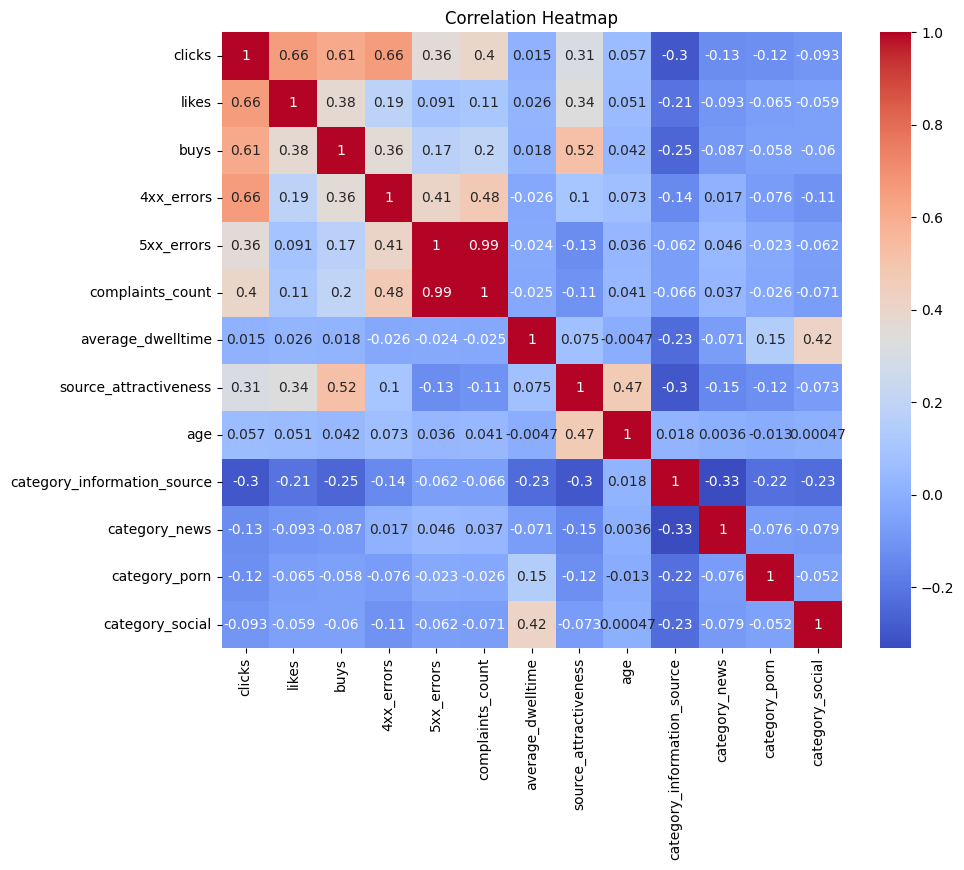

In [8]:
# Plot correlation heatmap for better visualization
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Correlation Heatmap')
plt.show()

Features distribution

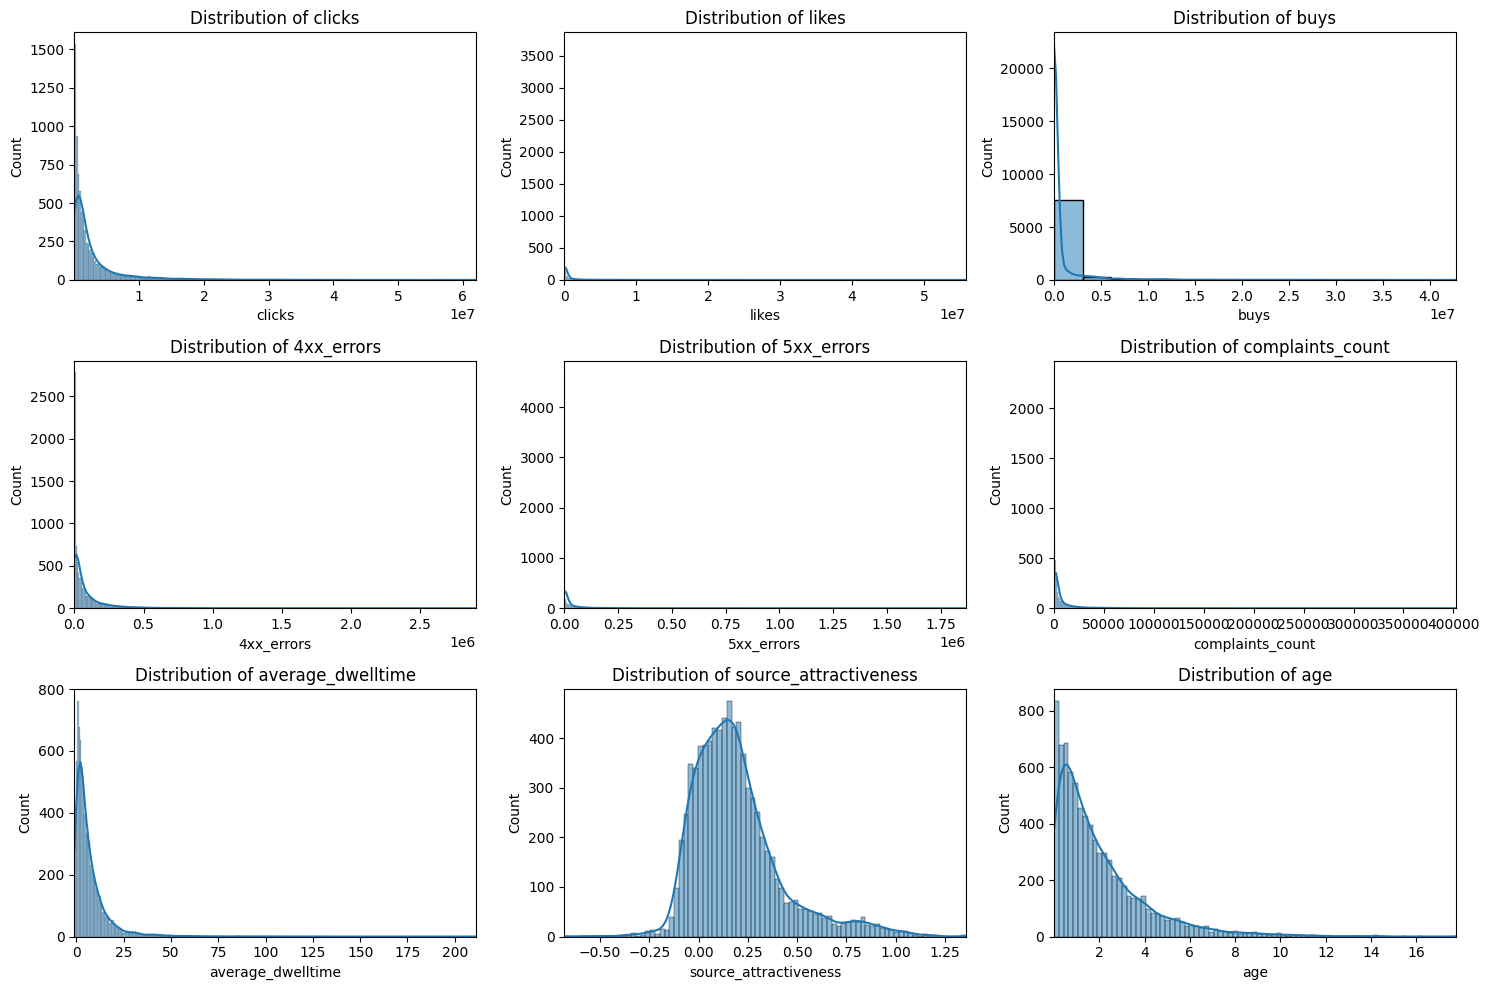

In [9]:

def plot_distribution(df: pd.DataFrame):
  plt.figure(figsize=(15, 10))
  for i, feature in enumerate(numerical_features, 1):
      plt.subplot(3, 3, i)
      s = df[feature]
      sns.histplot(s, kde=True)
      plt.xlim(s.min(), s.max())
      plt.title(f'Distribution of {feature}')

  plt.tight_layout()
  plt.show()

plot_distribution(df)

category
information_source    3934
ecom                  2452
news                   816
social                 415
porn                   383
Name: count, dtype: int64


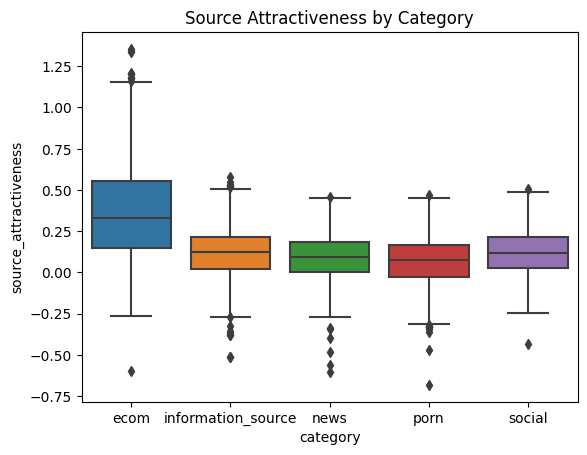

In [10]:
# Analyzing categorical feature (category)
print(df['category'].value_counts())
sns.boxplot(x='category', y='source_attractiveness', data=df)
plt.title('Source Attractiveness by Category')
plt.show()

In [11]:
encoded.describe()

,clicks,likes,buys,4xx_errors,5xx_errors,complaints_count,average_dwelltime,source_attractiveness,age,category_information_source,category_news,category_porn,category_social
count,7.727000e+03,7.624000e+03,8.000000e+03,8.000000e+03,8.000000e+03,7116.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000,8000.000000
mean,2.749785e+06,5.985027e+05,5.810509e+05,8.204958e+04,2.769224e+04,6418.338252,6.979549,0.191997,2.005641,0.491750,0.102000,0.047875,0.051875
std,4.699120e+06,1.978345e+06,2.262221e+06,1.555219e+05,7.946935e+04,16082.069321,10.004924,0.227873,2.025067,0.499963,0.302667,0.213515,0.221788
min,5.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,-1.000000,-0.681718,0.000535,0.000000,0.000000,0.000000,0.000000
25%,3.599210e+05,0.000000e+00,0.000000e+00,2.943000e+03,0.000000e+00,144.500000,1.503928,0.038220,0.585100,0.000000,0.000000,0.000000,0.000000
50%,1.097221e+06,3.399550e+04,0.000000e+00,2.671750e+04,0.000000e+00,1393.000000,4.022802,0.154256,1.381715,0.000000,0.000000,0.000000,0.000000
75%,2.915358e+06,2.860638e+05,0.000000e+00,9.500225e+04,2.016375e+04,5099.750000,8.899400,0.282510,2.743200,1.000000,0.000000,0.000000,0.000000
max,6.203206e+07,5.582181e+07,4.277391e+07,2.904996e+06,1.865588e+06,402119.000000,211.218066,1.355736,17.726856,1.000000,1.000000,1.000000,1.000000


Using SimpleImputer to fill missing values with the mean for numerical columns

In [12]:
numerical_imputer = SimpleImputer(strategy='mean')
encoded[numerical_features] = numerical_imputer.fit_transform(encoded[numerical_features])

Drop incorrect data

In [13]:
encoded.drop(encoded[encoded['average_dwelltime'] < 0].index, inplace=True)
encoded.describe()

,clicks,likes,buys,4xx_errors,5xx_errors,complaints_count,average_dwelltime,source_attractiveness,age,category_information_source,category_news,category_porn,category_social
count,7.593000e+03,7.593000e+03,7.593000e+03,7.593000e+03,7.593000e+03,7593.000000,7593.000000,7593.000000,7593.000000,7593.000000,7593.000000,7593.000000,7593.000000
mean,2.756471e+06,6.056803e+05,5.812593e+05,8.162372e+04,2.729469e+04,6345.882541,7.407269,0.192099,2.015087,0.492427,0.101541,0.047544,0.052417
std,4.631128e+06,1.949456e+06,2.266554e+06,1.545150e+05,7.829674e+04,15026.820502,10.092981,0.227387,2.037700,0.499976,0.302063,0.212813,0.222881
min,5.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000997,-0.681718,0.000535,0.000000,0.000000,0.000000,0.000000
25%,3.785540e+05,0.000000e+00,0.000000e+00,2.945000e+03,0.000000e+00,288.000000,1.837982,0.038656,0.586873,0.000000,0.000000,0.000000,0.000000
50%,1.180070e+06,4.468400e+04,0.000000e+00,2.690800e+04,0.000000e+00,1798.000000,4.384810,0.154754,1.380364,0.000000,0.000000,0.000000,0.000000
75%,2.807776e+06,4.108640e+05,0.000000e+00,9.496800e+04,2.020300e+04,6418.338252,9.276874,0.282519,2.755364,1.000000,0.000000,0.000000,0.000000
max,6.203206e+07,5.582181e+07,4.277391e+07,2.904996e+06,1.865588e+06,402119.000000,211.218066,1.355736,17.726856,1.000000,1.000000,1.000000,1.000000


See the difference after data cleaning and preprocessing.

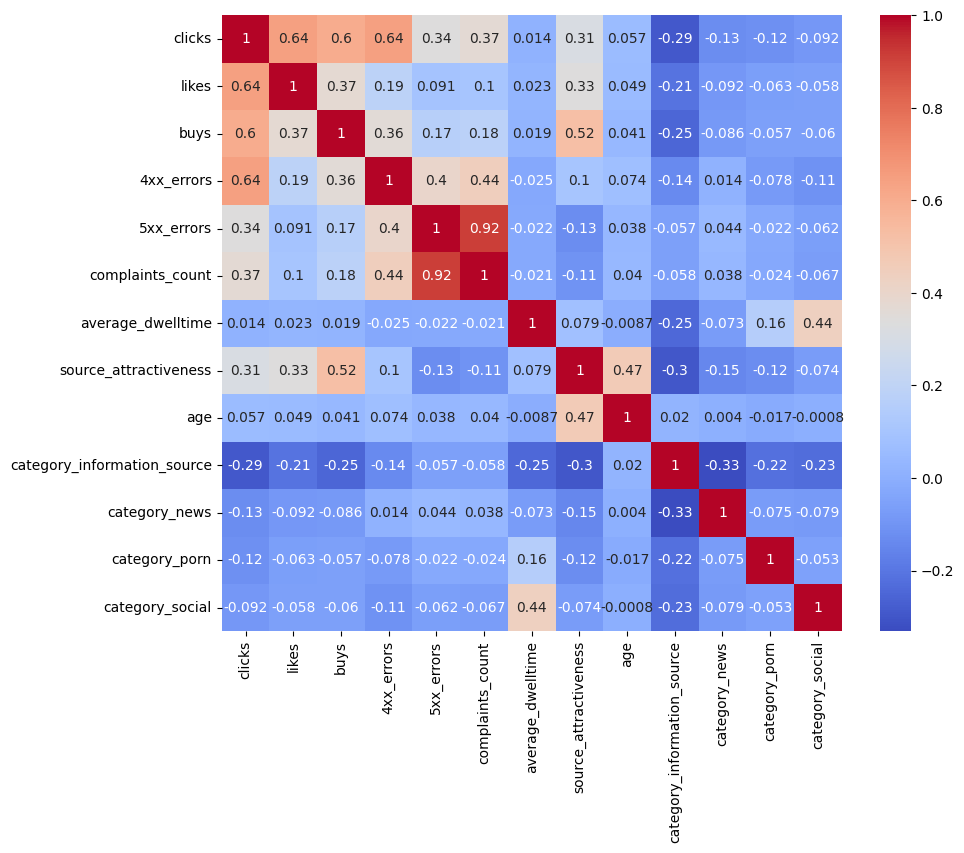

In [15]:
correlation_matrix = encoded.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.show()

complaints_count feature in 92% correlation with 5xx_erros feature, so I'll get rid of it

In [16]:
encoded.drop(columns='complaints_count', axis=1, inplace=True)
numerical_features.remove('complaints_count')

In [17]:
encoded.describe()

,clicks,likes,buys,4xx_errors,5xx_errors,average_dwelltime,source_attractiveness,age,category_information_source,category_news,category_porn,category_social
count,7.593000e+03,7.593000e+03,7.593000e+03,7.593000e+03,7.593000e+03,7593.000000,7593.000000,7593.000000,7593.000000,7593.000000,7593.000000,7593.000000
mean,2.756471e+06,6.056803e+05,5.812593e+05,8.162372e+04,2.729469e+04,7.407269,0.192099,2.015087,0.492427,0.101541,0.047544,0.052417
std,4.631128e+06,1.949456e+06,2.266554e+06,1.545150e+05,7.829674e+04,10.092981,0.227387,2.037700,0.499976,0.302063,0.212813,0.222881
min,5.100000e+01,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000997,-0.681718,0.000535,0.000000,0.000000,0.000000,0.000000
25%,3.785540e+05,0.000000e+00,0.000000e+00,2.945000e+03,0.000000e+00,1.837982,0.038656,0.586873,0.000000,0.000000,0.000000,0.000000
50%,1.180070e+06,4.468400e+04,0.000000e+00,2.690800e+04,0.000000e+00,4.384810,0.154754,1.380364,0.000000,0.000000,0.000000,0.000000
75%,2.807776e+06,4.108640e+05,0.000000e+00,9.496800e+04,2.020300e+04,9.276874,0.282519,2.755364,1.000000,0.000000,0.000000,0.000000
max,6.203206e+07,5.582181e+07,4.277391e+07,2.904996e+06,1.865588e+06,211.218066,1.355736,17.726856,1.000000,1.000000,1.000000,1.000000


In [18]:
encoded.head()

,clicks,likes,buys,4xx_errors,5xx_errors,average_dwelltime,source_attractiveness,age,category_information_source,category_news,category_porn,category_social
ID,,,,,,,,,,,,
6622,6488536.0,598502.743179,0.0,82221.0,0.0,18.450527,0.461750,4.444740,0,0,0,0
2047,874840.0,21100.000000,0.0,12872.0,0.0,10.721619,-0.022317,0.197279,1,0,0,0
1118,571210.0,94707.000000,0.0,0.0,7420.0,1.922243,0.046396,0.214544,1,0,0,0
4992,89534.0,924.000000,0.0,834.0,0.0,2.149243,-0.093360,0.052342,0,1,0,0
9970,1043953.0,289288.000000,0.0,58375.0,20260.0,3.764965,0.027303,0.346676,1,0,0,0


Let's add new features

In [19]:
featured = encoded.copy(deep=True)
featured['bpc'] = featured['buys'] / featured['clicks']
featured['lpc'] = featured['likes'] / featured['clicks']

featured['performance'] = -(featured['5xx_errors'] + featured['4xx_errors']) / featured['clicks']
featured['time_spent'] = featured['average_dwelltime'] * featured['clicks']

featured.drop(
    columns=['likes', 'buys', '5xx_errors', '4xx_errors', 'average_dwelltime'],
    axis=1,
    inplace=True)

numerical_features = [
    'bpc', 'lpc', 'performance', 'time_spent',
    'clicks', 'source_attractiveness', 'age'
]

featured.head()

,clicks,source_attractiveness,age,category_information_source,category_news,category_porn,category_social,bpc,lpc,performance,time_spent
ID,,,,,,,,,,,
6622,6488536.0,0.461750,4.444740,0,0,0,0,0.0,0.092240,-0.012672,1.197169e+08
2047,874840.0,-0.022317,0.197279,1,0,0,0,0.0,0.024119,-0.014714,9.379701e+06
1118,571210.0,0.046396,0.214544,1,0,0,0,0.0,0.165801,-0.012990,1.098004e+06
4992,89534.0,-0.093360,0.052342,0,1,0,0,0.0,0.010320,-0.009315,1.924303e+05
9970,1043953.0,0.027303,0.346676,1,0,0,0,0.0,0.277108,-0.075324,3.930447e+06


By trial and error it turned out that it is better to normalize performance data by Yeo-Johnson transformation
and other data by taking logarithms

In [20]:
but_performance = [
    'bpc', 'lpc', 'time_spent',
    'clicks', 'source_attractiveness', 'age'
]

featured[but_performance] = np.log1p(featured[but_performance])

featured['performance'] = PowerTransformer(method='yeo-johnson') \
                     .fit_transform(featured[['performance']])

In [21]:
featured.describe()

,clicks,source_attractiveness,age,category_information_source,category_news,category_porn,category_social,bpc,lpc,performance,time_spent
count,7593.000000,7593.000000,7593.000000,7593.000000,7593.000000,7593.000000,7593.000000,7593.000000,7593.000000,7.593000e+03,7593.000000
mean,13.775177,0.159168,0.925063,0.492427,0.101541,0.047544,0.052417,0.067589,0.150754,-1.497258e-17,15.080651
std,1.707274,0.178872,0.577611,0.499976,0.302063,0.212813,0.222881,0.170294,0.270271,1.000066e+00,2.189480
min,3.951244,-1.144817,0.000535,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-2.223872e+00,4.343739
25%,12.844117,0.037928,0.461766,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,-7.834913e-01,13.770846
50%,13.981085,0.143888,0.867253,0.000000,0.000000,0.000000,0.000000,0.000000,0.073359,8.284831e-02,15.288478
75%,14.847904,0.248826,1.323185,1.000000,0.000000,0.000000,0.000000,0.000000,0.217151,8.604655e-01,16.564599
max,17.943162,0.856853,2.929959,1.000000,1.000000,1.000000,1.000000,2.237425,8.285159,1.406009e+00,21.200983


In [22]:
featured.head()

,clicks,source_attractiveness,age,category_information_source,category_news,category_porn,category_social,bpc,lpc,performance,time_spent
ID,,,,,,,,,,,
6622,15.685548,0.379635,1.694650,0,0,0,0,0.0,0.088231,0.875022,18.600640
2047,13.681797,-0.022570,0.180052,1,0,0,0,0.0,0.023832,0.797603,16.054059
1118,13.255514,0.045352,0.194368,1,0,0,0,0.0,0.153408,0.862816,13.909006
4992,11.402385,-0.098010,0.051018,0,1,0,0,0.0,0.010267,1.006993,12.167495
9970,13.858526,0.026937,0.297639,1,0,0,0,0.0,0.244598,-0.766327,15.184264


This is what we managed to achieve

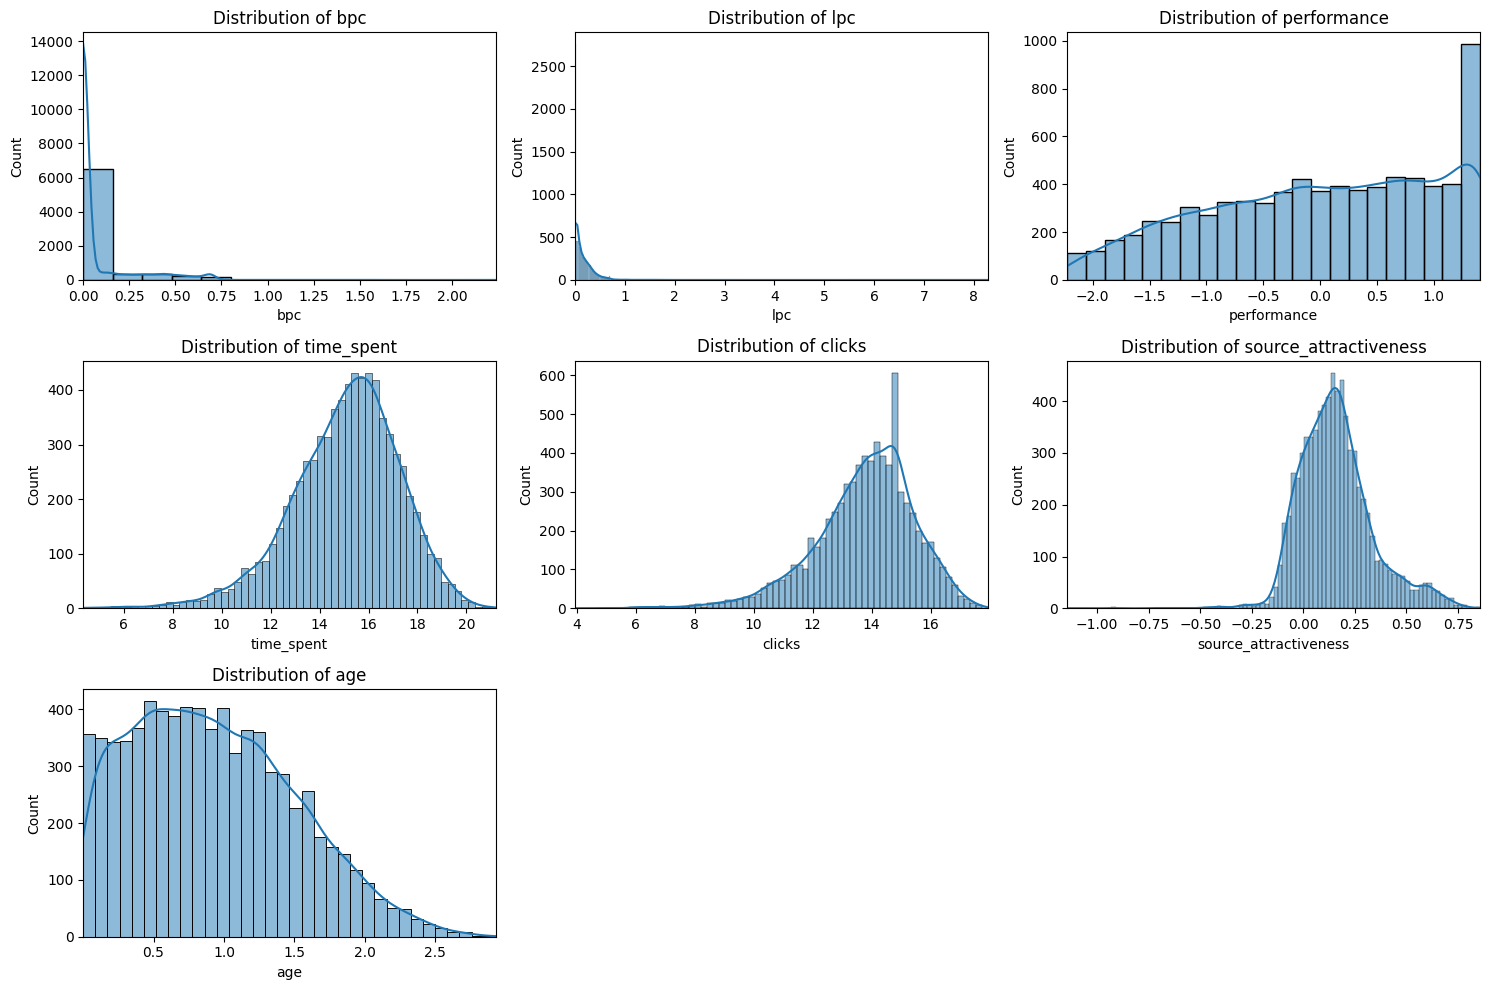

In [23]:
plot_distribution(featured)

Let's build source_atrractivness dependencies graphics.
As if it wasn't so bad.

In [24]:


attractiveness = make_subplots(
    rows=3, cols=2,
    specs=[
        [{"colspan": 2}, None],
        [{}, {}],
        [{}, {}],
    ]
)

attractiveness.add_scatter(
    x=(featured['bpc'] + featured['lpc']), y=featured['source_attractiveness'],
    mode='markers', marker=dict(size=1),
    name='Активность',
    row=1, col=1,
)
attractiveness.update_xaxes(row=1, col=1, title_text='Активность', range=[0, 2])
attractiveness.update_yaxes(row=1, col=1, title_text='Привлекательность')

attractiveness.add_scatter(
    x=featured['lpc'], y=featured['source_attractiveness'],
    mode='markers', marker=dict(size=1),
    name='Лайки за клик',
    row=2, col=1,
)
attractiveness.update_xaxes(row=2, col=1, title_text='Лайков за клик', range=[0, 1])
attractiveness.update_yaxes(row=2, col=1, title_text='Привлекательность')


attractiveness.add_scatter(
    x=featured['bpc'], y=featured['source_attractiveness'],
    mode='markers', marker=dict(size=1),
    name='Покупки за клик',
    row=2, col=2,
)
attractiveness.update_xaxes(row=2, col=2, title_text='Покупок за клик', range=[0, 1])
attractiveness.update_yaxes(row=2, col=2, title_text='Привлекательность')

attractiveness.add_scatter(
    x=featured['performance'], y=featured['source_attractiveness'],
    mode='markers', marker=dict(size=1),
    name='Опыт',
    row=3, col=1,
)
attractiveness.update_xaxes(row=3, col=1, title_text='Работоспособность', range=[-0.5, 0.5])
attractiveness.update_yaxes(row=3, col=1, title_text='Привлекательность')


attractiveness.add_scatter(
    x=featured['time_spent'], y=featured['source_attractiveness'],
    mode='markers', marker=dict(size=1.5),
    name='Время',
    row=3, col=2,
)
attractiveness.update_xaxes(row=3, col=2, title_text='Проведенное время')
attractiveness.update_yaxes(row=3, col=2, title_text='Привлекательность')
 

attractiveness.update(
    layout=dict(
        width=900, height=900,
    )
)
attractiveness.show()

Well, let's try it out!

In [25]:
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

X = featured.drop(columns=['source_attractiveness'], axis=1)
y = featured['source_attractiveness']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25) 

model = LinearRegression()

model.fit(X_train, y_train) 
y_pred = model.predict(X_test)


from sklearn.metrics import mean_absolute_error,mean_squared_error 
  
mae = mean_absolute_error(y_true=y_test,y_pred=y_pred) 
mse = mean_squared_error(y_true=y_test,y_pred=y_pred) #default=True 
rmse = mean_squared_error(y_true=y_test,y_pred=y_pred,squared=False) 
  
print("MAE:",mae) 
print("MSE:",mse) 
print("RMSE:",rmse)
featured.head()


MAE: 0.048705529811560275
MSE: 0.005122408410944613
RMSE: 0.07157100258445884


,clicks,source_attractiveness,age,category_information_source,category_news,category_porn,category_social,bpc,lpc,performance,time_spent
ID,,,,,,,,,,,
6622,15.685548,0.379635,1.694650,0,0,0,0,0.0,0.088231,0.875022,18.600640
2047,13.681797,-0.022570,0.180052,1,0,0,0,0.0,0.023832,0.797603,16.054059
1118,13.255514,0.045352,0.194368,1,0,0,0,0.0,0.153408,0.862816,13.909006
4992,11.402385,-0.098010,0.051018,0,1,0,0,0.0,0.010267,1.006993,12.167495
9970,13.858526,0.026937,0.297639,1,0,0,0,0.0,0.244598,-0.766327,15.184264


Seemed good, so let's work with test data:

In [26]:
def date_to_age(df: pd.DataFrame):    
    df['date_of_registration'] = pd.to_datetime(df['date_of_registration'])
    df['age'] = (pd.Timestamp('2024-09-30') - df['date_of_registration']) / pd.Timedelta(days=365)
    df.drop('date_of_registration', axis='columns', inplace=True)

def prepare_data(df: pd.DataFrame):
    date_to_age(df)

    numerical_features = [
        'clicks', 
        'likes', 
        'buys', 
        '4xx_errors', 
        '5xx_errors',
        'complaints_count', 
        'average_dwelltime', 
        'age'
    ]

    category_features = [
        'category_information_source',	
        'category_news',	
        'category_porn',	
        'category_social'
    ]

    for feature in numerical_features:
        df[feature] = pd.to_numeric(df[feature], errors='coerce')

    df = pd.get_dummies(df, columns=['category'], drop_first=True, dtype=int)
    
    numerical_imputer = SimpleImputer(strategy='mean')
    df[numerical_features] = numerical_imputer.fit_transform(df[numerical_features])

    # df.drop(df[df['average_dwelltime'] < 0].index, inplace=True)
    df['average_dwelltime'] = df['average_dwelltime'].apply(lambda x: 0 if x < 0 else x)

    df.drop(columns='complaints_count', axis=1, inplace=True)
    numerical_features.remove('complaints_count')

    df['bpc'] = df['buys'] / df['clicks']
    df['lpc'] = df['likes'] / df['clicks']

    df['performance'] = -(df['5xx_errors'] + df['4xx_errors']) / df['clicks']
    df['time_spent'] = df['average_dwelltime'] * df['clicks']

    df.drop(
        columns=['likes', 'buys', '5xx_errors', '4xx_errors', 'average_dwelltime'],
        axis=1,
        inplace=True)

    numerical_features = [
        'bpc', 'lpc', 'performance', 'time_spent',
        'clicks', 'age'
    ]

    but_performance = [
        'bpc', 'lpc', 'time_spent',
        'clicks', 'age'
    ]
    df[but_performance] = np.log1p(df[but_performance])

    df['performance'] = PowerTransformer(method='yeo-johnson') \
                        .fit_transform(df[['performance']])
    return df

def predict(data_path):
    df = pd.read_csv(data_path)
    df = prepare_data(df)
    return model.predict(df.drop('ID', axis=1))

y_pred = predict('test.csv')
data = {
    "source_attractiveness": y_pred
}
submit = pd.DataFrame(data)
submit.to_csv('submission.csv', index_label="ID")